In [157]:
%matplotlib inline
import requests
import jsm
from bs4 import BeautifulSoup
import sqlite3
import pandas as pd

In [153]:
q = jsm.Quotes()
b = q.get_brand()
ccodes = []
d = {}
for key in b:
    for i in b[key]:
        ccodes.append(i.ccode)
        d[i.ccode] = i.name

/home/nwata/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /home/nwata/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [ ]:
conn = sqlite3.connect('income_per_person.db')
c = conn.cursor()
c.execute('CREATE TABLE IF NOT EXISTS ccodes(ccode INTEGER)')
c.executemany('INSERT INTO ccodes values (?)', [(i,) for i in codes])
conn.commit()

In [115]:
def get_profit(ccode):
    r = requests.get('https://profile.yahoo.co.jp/consolidate/{}'.format(ccode))
    bs = BeautifulSoup(r.text, 'lxml')
    text = bs.findAll('td')[39].text
    num = ''.join(s for s in text if s.isdigit())
    return int(num) if num else -1

def get_num_employees(ccode):
    r = requests.get('https://profile.yahoo.co.jp/fundamental/{}'.format(ccode))
    bs = BeautifulSoup(r.text, 'lxml')
    text = bs.findAll('td', attrs = {"width": "25%"})[-1].text
    num = ''.join(s for s in text if s.isdigit())
    return int(num) if num else -1

In [ ]:
data = []
for ccode in ccodes:
    pft = get_profit(ccode)
    num = get_num_employees(ccode)
    per = round(pft / num, 2) if pft > 0 and num > 0 else -1
    datum = (ccode, pft, num, per)
    data.append(datum)

In [136]:
c.execute('CREATE TABLE per_person(ccode INTEGER, income INTEGER, employee INTEGER, per_person REAL)')
c.executemany('INSERT INTO per_person VALUES (?, ?, ?, ?)', data)
conn.commit()

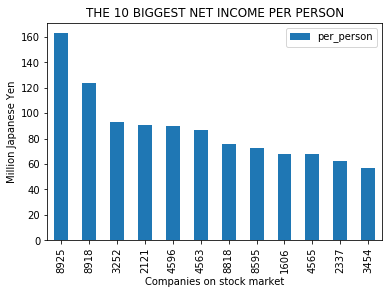

In [190]:
df = pd.io.sql.read_sql_query('SELECT ccode, per_person FROM per_person WHERE per_person > 0 ORDER BY per_person DESC limit 12', conn)
df['name'] = df['ccode'].map(lambda ccode: d[str(ccode)])
ax = df.plot.bar(x='ccode', y='per_person')
ax.set_title('THE 10 BIGGEST NET INCOME PER PERSON')
ax.set_xlabel('Companies on stock market')
ax.set_ylabel('Million Japanese Yen')

In [191]:
conn.close()